In [1]:
%matplotlib inline
import os 
import glob 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import MinMaxScaler 

import warnings 
warnings.filterwarnings('ignore') 

path = r'./archive/oneyeardata/' 
all_files = glob.glob(os.path.join(path, '*.csv')) 
sensors = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True) 
sensors.head()

,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
0,0.008,0.199603,0.027420,628392628,-920.104980,5298555,2441.235352,0.899543,1379.999756
1,0.012,0.281624,0.002502,628392625,-937.271118,5298565,2453.819092,0.874072,1379.999756
2,0.016,0.349315,-0.018085,628392621,-951.004028,5298575,2476.469727,0.879806,1379.999756
3,0.020,0.444450,-0.054680,628392617,-1019.668579,5298585,2501.637207,0.837500,1379.999756
4,0.024,0.480923,-0.042770,628392613,-1023.101807,5298595,2519.254395,0.905347,1379.999756


In [2]:
print(sensors.dtypes)

timestamp                                               float64
pCut::Motor_Torque                                      float64
pCut::CTRL_Position_controller::Lag_error               float64
pCut::CTRL_Position_controller::Actual_position           int64
pCut::CTRL_Position_controller::Actual_speed            float64
pSvolFilm::CTRL_Position_controller::Actual_position      int64
pSvolFilm::CTRL_Position_controller::Actual_speed       float64
pSvolFilm::CTRL_Position_controller::Lag_error          float64
pSpintor::VAX_speed                                     float64
dtype: object


In [3]:
print(sensors.shape)

(1062912, 9)


In [4]:
sensors.drop_duplicates(inplace=True)
print(sensors.nunique(axis=0))

timestamp                                                  2164
pCut::Motor_Torque                                      1052276
pCut::CTRL_Position_controller::Lag_error                469965
pCut::CTRL_Position_controller::Actual_position          977299
pCut::CTRL_Position_controller::Actual_speed               7771
pSvolFilm::CTRL_Position_controller::Actual_position    1059344
pSvolFilm::CTRL_Position_controller::Actual_speed         15618
pSvolFilm::CTRL_Position_controller::Lag_error          1001942
pSpintor::VAX_speed                                        6800
dtype: int64


In [5]:
sensors_outliers = pd.DataFrame(sensors.loc[:, sensors.columns != 'timestamp']) 
Q1 = sensors_outliers.quantile(0.25) 
Q3 = sensors_outliers.quantile(0.75)   
IQR = Q3 - Q1
for i, j in zip(np.where(sensors_outliers > Q3 + 1.5 * IQR)[0], np.where(sensors_outliers > Q3 + 1.5 * IQR)[1]): 
    whisker = Q3 + 1.5 * IQR 
    sensors_outliers.iloc[i,j] = whisker[j] 
    
for i, j in zip(np.where(sensors_outliers < Q1 - 1.5 * IQR)[0], np.where(sensors_outliers < Q1 - 1.5 * IQR)[1]): 
    whisker = Q1 - 1.5 * IQR 
    sensors_outliers.iloc[i,j] = whisker[j]    
    
sensors.drop(columns= sensors.loc[:,], inplace=True) 
sensors = pd.concat([sensors, sensors_outliers], axis=1) 


<Axes: >

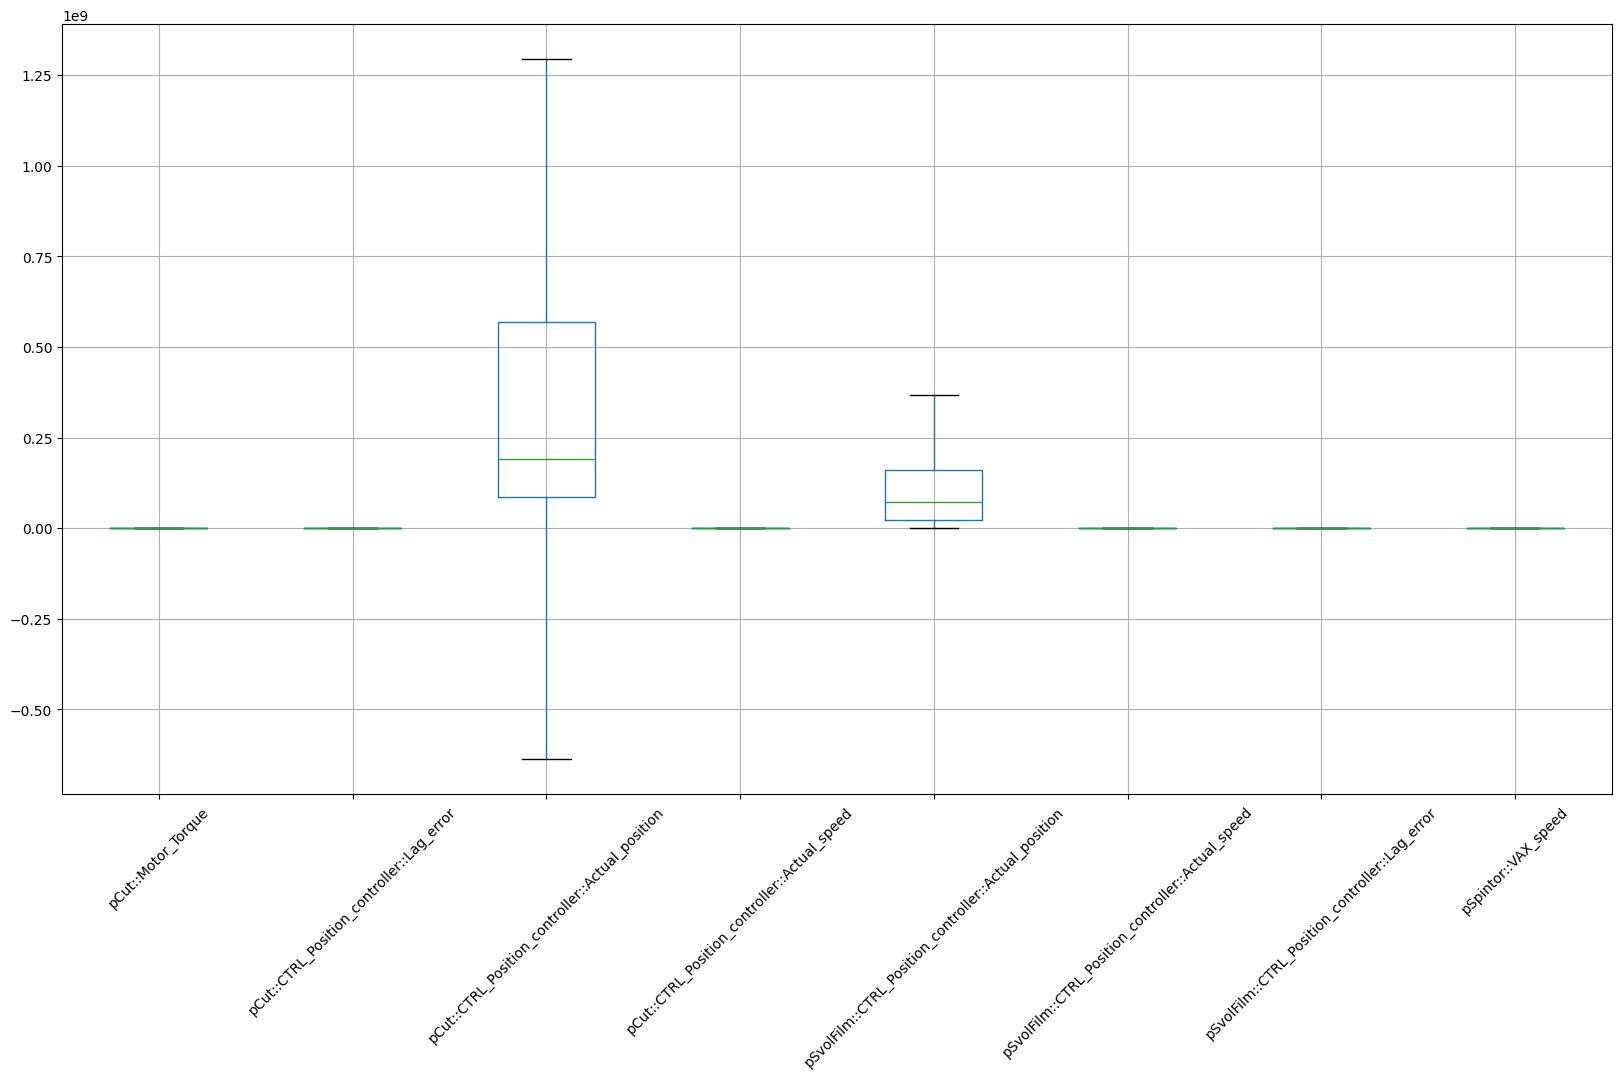

In [6]:
sensors.boxplot(rot=45, figsize=(20, 10))

<Axes: >

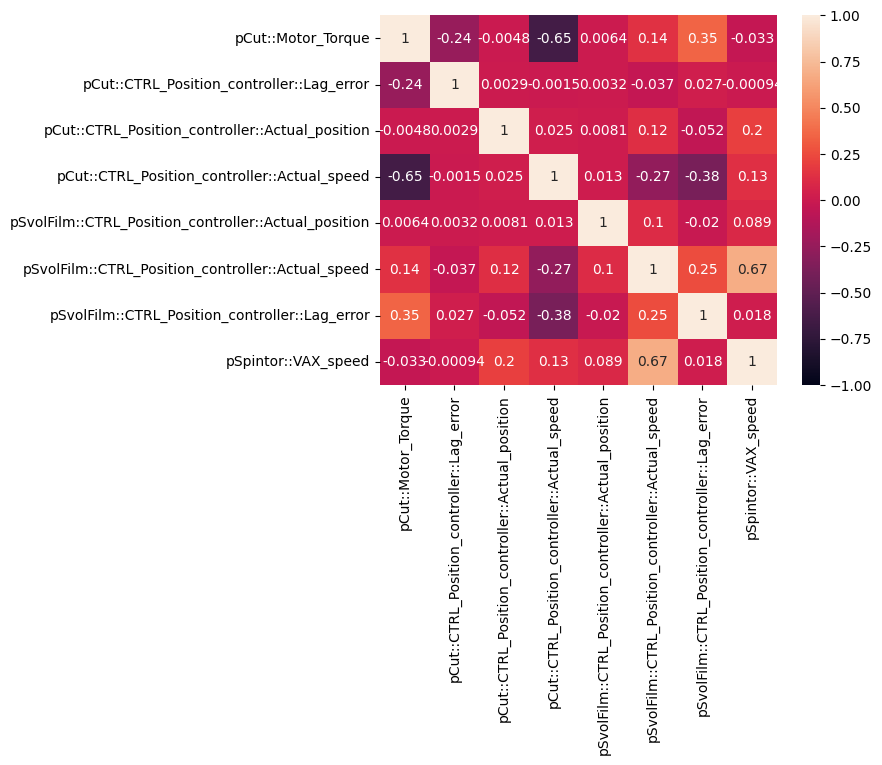

In [7]:
sns.heatmap(sensors.corr(numeric_only=True), vmin=-1, vmax=1, annot=True) 

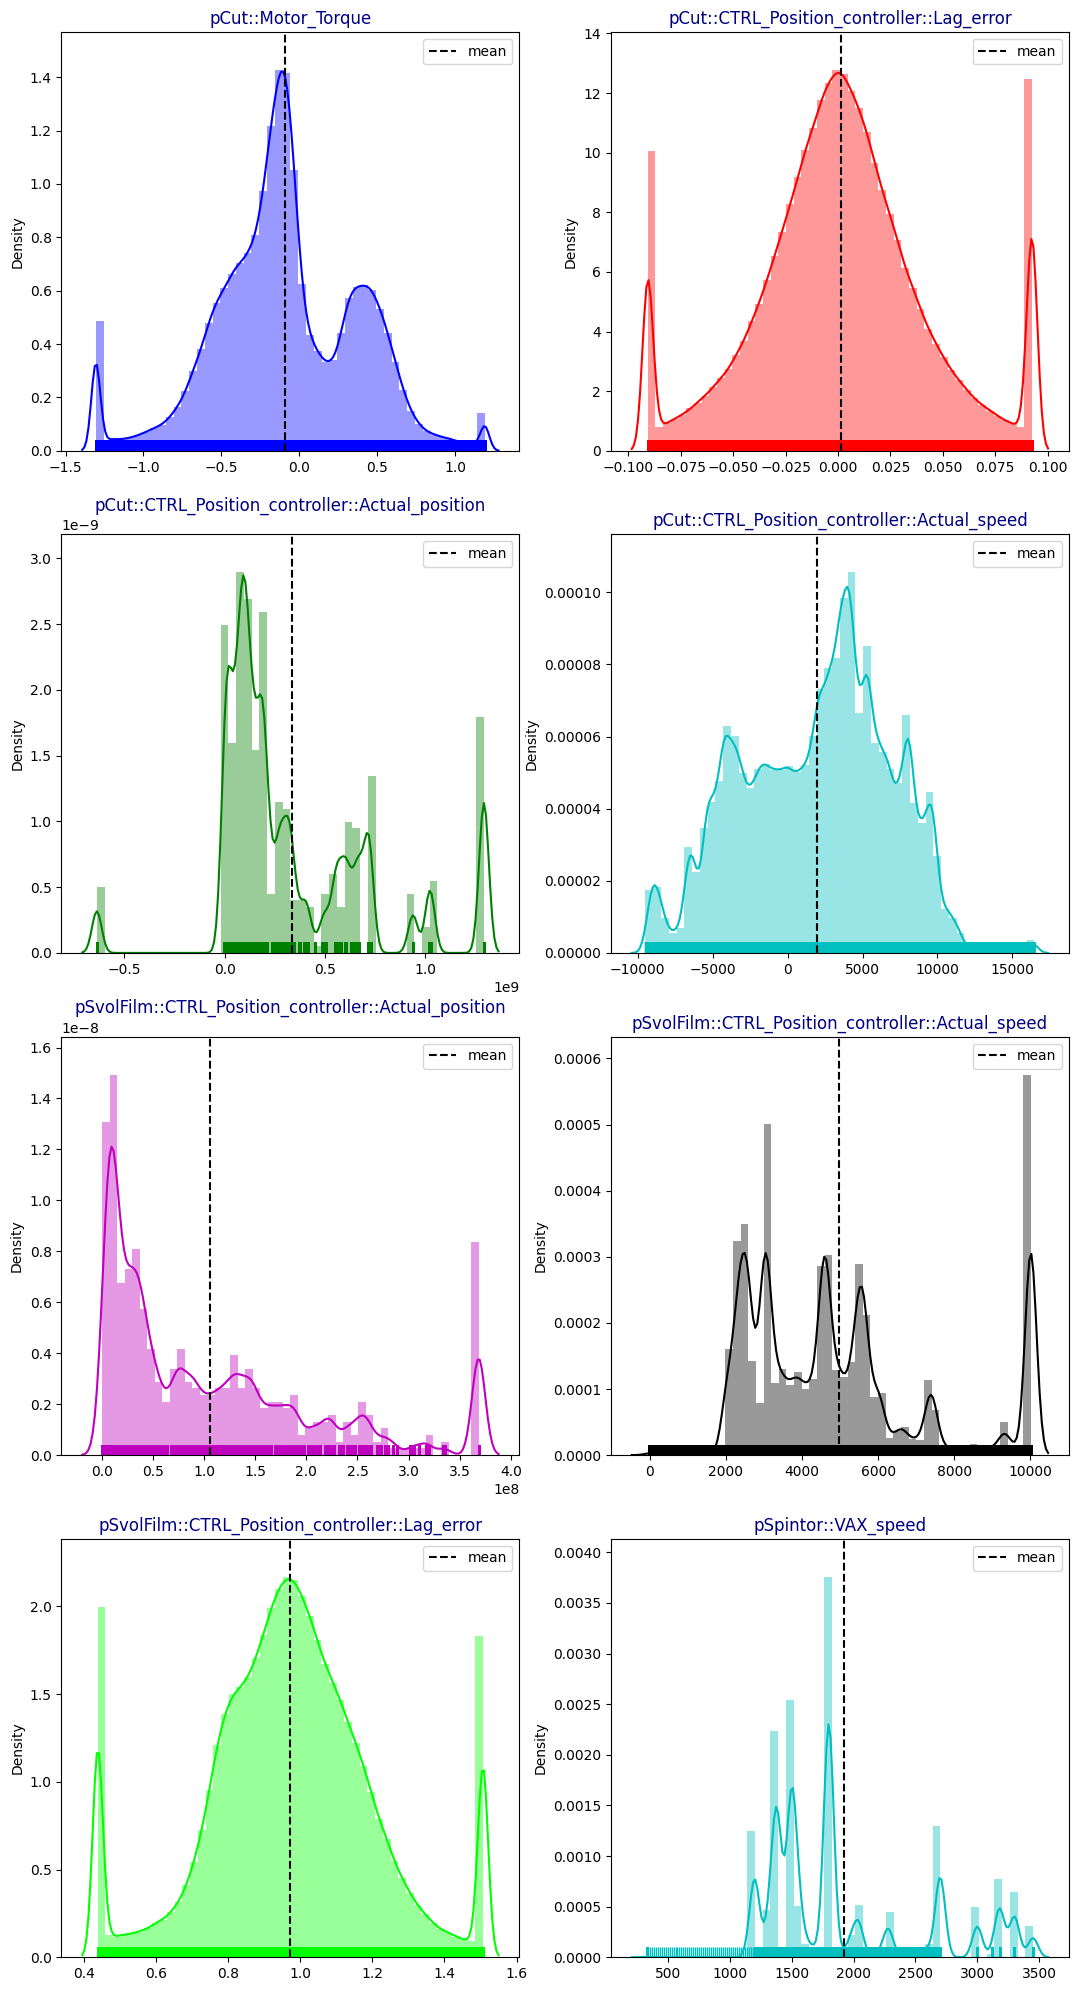

In [8]:
import itertools 
cols = [i for i in sensors.columns if i not in ['timestamp']]  
length = len(cols)
cs = ['b', 'r', 'g', 'c', 'm', 'k', 'lime', 'c'] 
fig = plt.figure(figsize=[13,25]) 

for i, j, k in itertools.zip_longest(cols, range(length), cs): 
    plt.subplot(4,2, j+1) 
    ax = sns.distplot(sensors[i], color=k, rug=True) 
    ax.set_facecolor('w') 
    plt.axvline(sensors[i].mean(), linestyle='dashed', label='mean', color='k') 
    plt.legend(loc='best') 
    plt.title(i, color='navy') 
    plt.xlabel('')

Text(0, 0.5, 'WCSS')

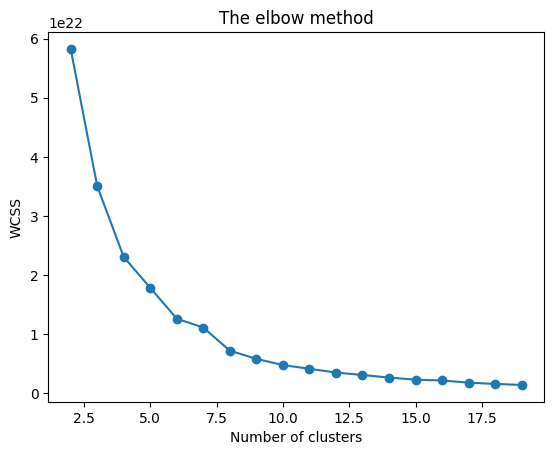

In [9]:
wcss = [] 

for i in range(2, 20): 
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=0) 
    kmeans.fit(sensors) 
    wcss.append(kmeans.inertia_) 
    
plt.plot(range(2, 20), wcss, marker='o')
plt.title('The elbow method') 
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS')

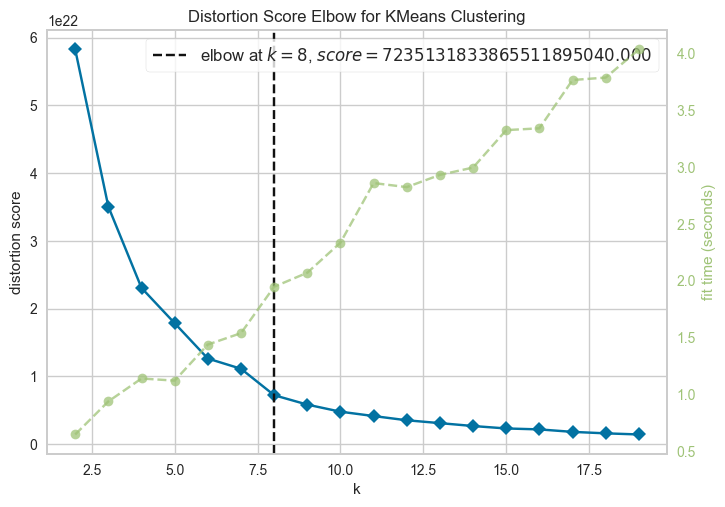

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from yellowbrick.cluster import KElbowVisualizer 
model = KMeans(n_clusters=1, init='k-means++', n_init=5, random_state=0) 
visualiser = KElbowVisualizer(model, k=(2, 20), timings=True) 
visualiser.fit(sensors) 
visualiser.show()

In [11]:
from jqmcvi import base 
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=5, random_state=0) 
kmeans.fit(sensors) 
ypred = kmeans.predict(sensors) 

pred = pd.DataFrame(ypred) 
pred.rename(columns={0: 'cluster'}, inplace=True) 

prediction = pd.concat([sensors, pred], axis=1)

In [12]:
from sklearn.metrics import davies_bouldin_score 
labels = kmeans.labels_ 
print(davies_bouldin_score(sensors, labels))

0.6086260677264023


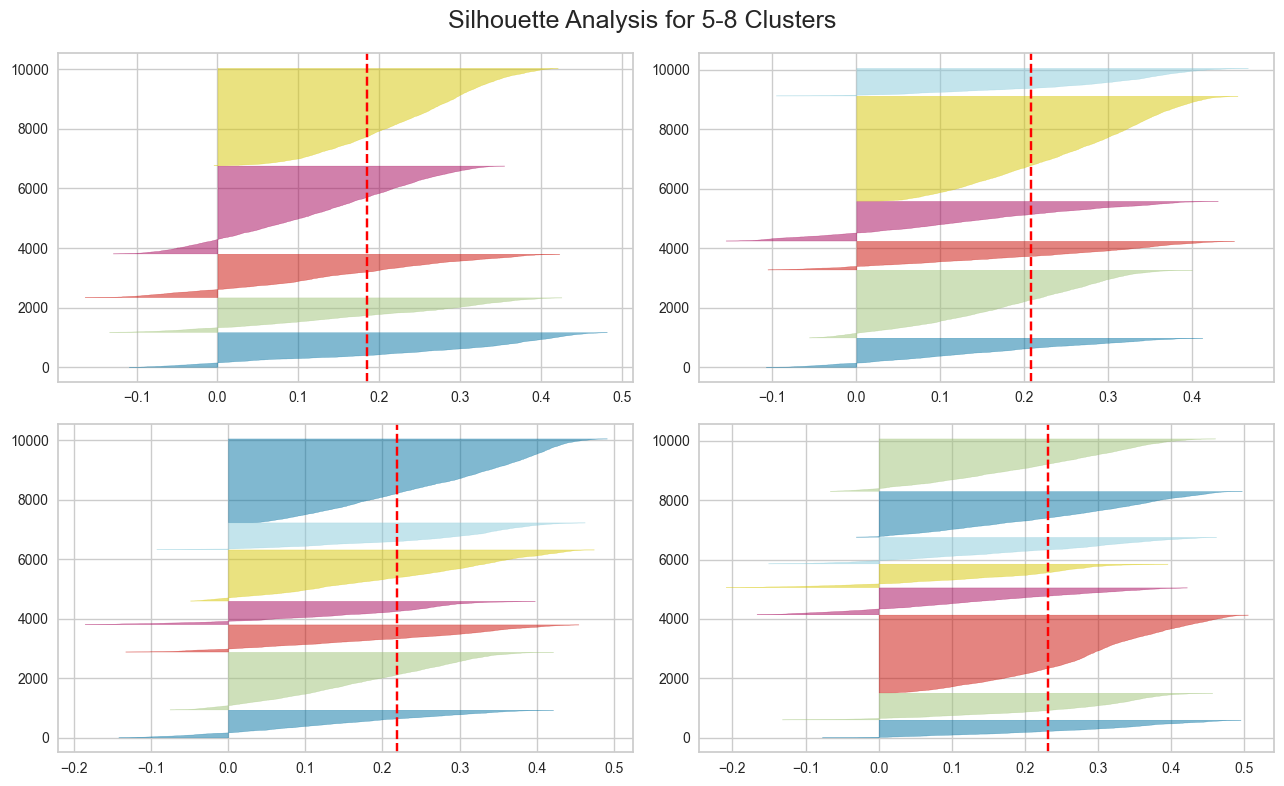

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np

# Scaling the data
scaler = MinMaxScaler()
sensors_scaled = scaler.fit_transform(sensors)

# Subsample the data BEFORE PCA for faster computation
# Subsampling to 10,000 rows for faster clustering
sensors_sampled = sensors_scaled[np.random.choice(sensors_scaled.shape[0], 10000, replace=False), :]

# Reduce dimensionality to 5 principal components using PCA
pca = PCA(n_components=5)
sensors_reduced = pca.fit_transform(sensors_sampled)

# Create a 2x2 grid of subplots for visualization
fig, ax = plt.subplots(2, 2, figsize=(13, 8))
fig.suptitle('Silhouette Analysis for 5-8 Clusters', size=18)
plt.tight_layout()

# Loop through clusters 5 to 8
for i in range(5, 9):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=2, random_state=0, max_iter=100, tol=1e-2)  # Parallelize with n_jobs=-1
    q, mod = divmod(i - 5, 2)  # Adjust divmod for subplot positioning

    # Silhouette visualizer for current clustering
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q, mod])
    visualizer.fit(sensors_reduced)  # Use reduced data for faster computation

plt.tight_layout()  # Apply layout adjustment after the plots
plt.show()


In [14]:
from sklearn.cluster import MiniBatchKMeans
for i in range(2, 15):
    # Use MiniBatchKMeans for faster execution
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', n_init=2, random_state=0, batch_size=500)
    
    # Fit the model and predict clusters
    labels = kmeans.fit_predict(sensors_reduced)
    
    # Calculate silhouette score
    score = silhouette_score(sensors_reduced, labels, metric='euclidean')
    
    print(f'Silhouette Average Score for {i} clusters: {score:.3f}')

Silhouette Average Score for 2 clusters: 0.283
Silhouette Average Score for 3 clusters: 0.278
Silhouette Average Score for 4 clusters: 0.158
Silhouette Average Score for 5 clusters: 0.217
Silhouette Average Score for 6 clusters: 0.203
Silhouette Average Score for 7 clusters: 0.217
Silhouette Average Score for 8 clusters: 0.198
Silhouette Average Score for 9 clusters: 0.236
Silhouette Average Score for 10 clusters: 0.171
Silhouette Average Score for 11 clusters: 0.215
Silhouette Average Score for 12 clusters: 0.224
Silhouette Average Score for 13 clusters: 0.216
Silhouette Average Score for 14 clusters: 0.189


Eucliean Distance: 0.08572276200891395


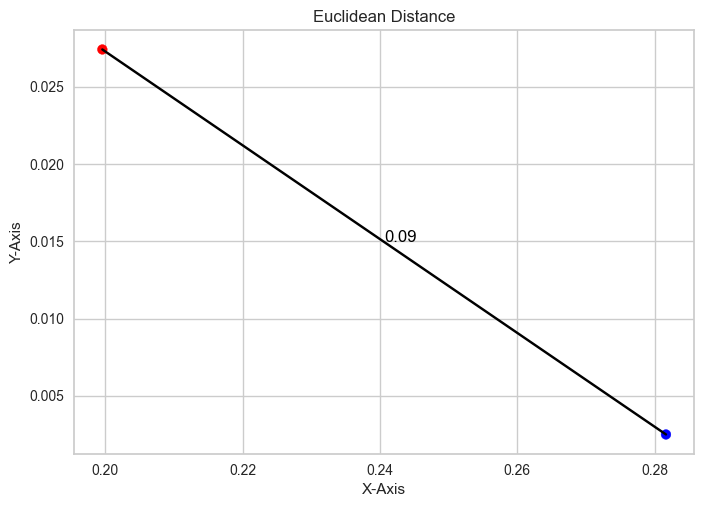

In [15]:
def euclidean_distance(point1, point2): 
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2)) 

point1 = sensors.iloc[0][:2] 
point2 = sensors.iloc[1][:2]
distance  = euclidean_distance(point1, point2) 
print(f"Eucliean Distance: {distance}") 

plt.figure() 
plt.scatter(*zip(*[point1, point2]), c=['red', 'blue']) 
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black') 
plt.text((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2, f'{distance:.2f}', color='black')  
plt.title('Euclidean Distance') 
plt.xlabel('X-Axis') 
plt.ylabel('Y-Axis') 
plt.show()

Manhattan Distance: 0.10693897000000001


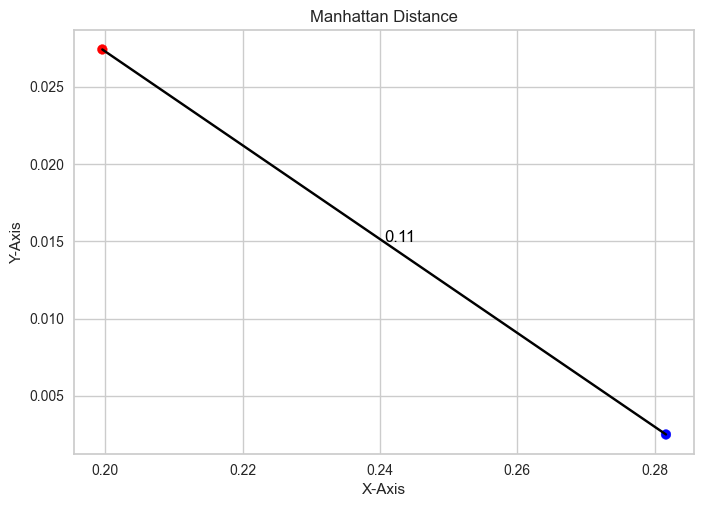

In [16]:
def manhattan_distance(point1, point2): 
    return np.sum(np.abs(np.array(point1) - np.array(point2)))  

distance1 = manhattan_distance(point1, point2) 
print(f"Manhattan Distance: {distance1}")  

plt.figure() 
plt.scatter(*zip(*[point1, point2]), c=['red', 'blue']) 
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black') 
plt.text((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2, f'{distance1:.2f}', color='black')  
plt.title('Manhattan Distance') 
plt.xlabel('X-Axis') 
plt.ylabel('Y-Axis') 
plt.show()

Cosine Similarity: 0.991865957541843


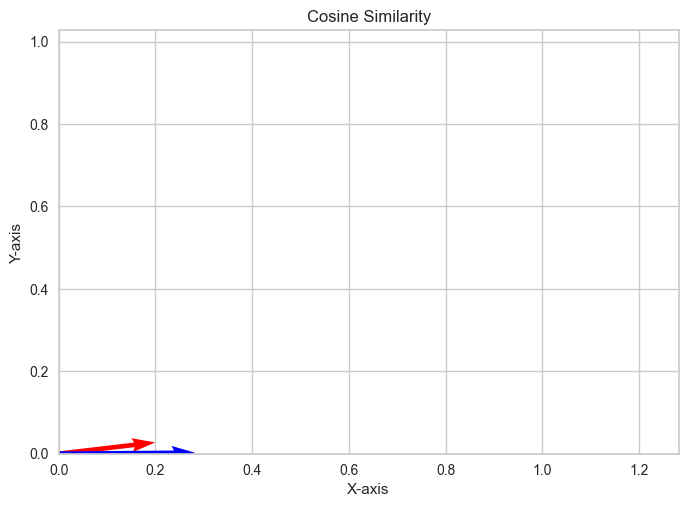

In [17]:
def consine_similarity(point1, point2): 
    dot_product = np.dot(point1, point2) 
    norm1 = np.linalg.norm(point1) 
    norm2 = np.linalg.norm(point2) 
    return dot_product / (norm1 * norm2)  

distance2 = consine_similarity(point1, point2) 
print(f"Cosine Similarity: {distance2}") 
origin = [0, 0] 
plt.figure() 
plt.quiver(*origin, *point1, angles='xy', scale_units='xy', scale=1, color='red')
plt.quiver(*origin, *point2, angles='xy', scale_units='xy', scale=1, color='blue')
plt.xlim(0, max(point1[0], point2[0]) + 1)
plt.ylim(0, max(point1[1], point2[1]) + 1)
plt.title('Cosine Similarity')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Minkowski Distance (p=3): 0.08278087050713584


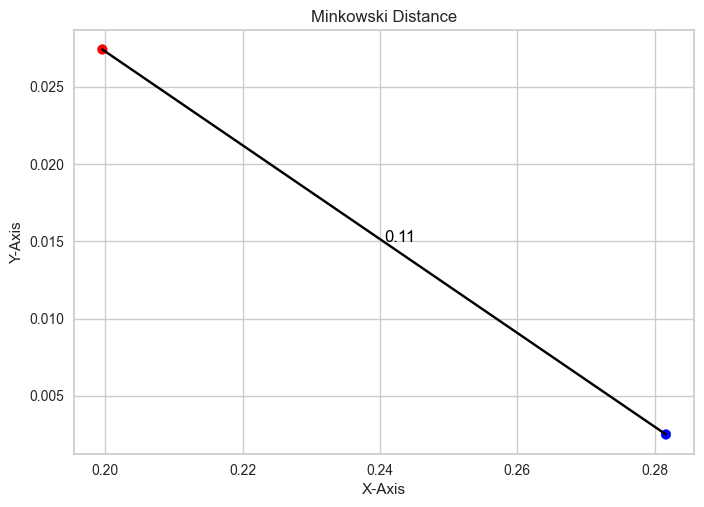

In [18]:
def minkowski_distance(point1, point2, p): 
    return np.power(np.sum(np.abs(np.array(point1) - np.array(point2)) ** p), 1/p) 

p = 3 
distance3 = minkowski_distance(point1, point2, p) 
print(f"Minkowski Distance (p={p}): {distance3}") 

plt.figure() 
plt.scatter(*zip(*[point1, point2]), c=['red', 'blue']) 
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black') 
plt.text((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2, f'{distance1:.2f}', color='black')  
plt.title('Minkowski Distance') 
plt.xlabel('X-Axis') 
plt.ylabel('Y-Axis') 
plt.show()

In [19]:
from sklearn.metrics import jaccard_score 
vector1 = sensors.iloc[0] 
vector2 = sensors.iloc[1]   
vector1_binary = np.where(vector1 > 0.5, 1, 0) 
vector2_binary = np.where(vector2 > 0.5, 1, 0) 
jaccard_index = jaccard_score(vector1_binary, vector2_binary) 
print(f"Jaccard Score: {jaccard_index}")

Jaccard Score: 1.0


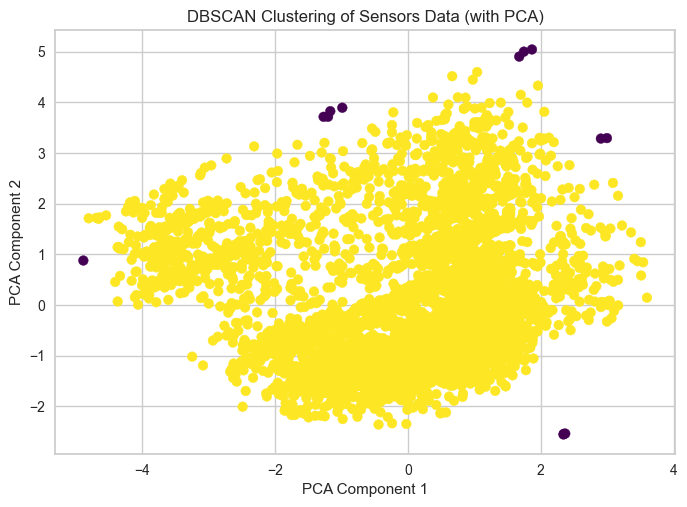

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'sensors' is your dataset
numeric_data = sensors.select_dtypes(include=[np.number])

# Standardize the data (DBSCAN works better with standardized data)
scaler = StandardScaler()
sensors_scaled = scaler.fit_transform(numeric_data)

# Optional: Subsample the data to speed up computation if your dataset is large
if sensors_scaled.shape[0] > 5000:  # Limit to 5000 samples
    sensors_scaled = sensors_scaled[np.random.choice(sensors_scaled.shape[0], 5000, replace=False), :]

# Set the number of PCA components to be less than or equal to the number of features
# Use min to automatically handle cases where the number of features is smaller
n_components = min(2, sensors_scaled.shape[1])  # You can adjust the number of components based on your needs

# Dimensionality reduction using PCA
pca = PCA(n_components=n_components)
sensors_reduced = pca.fit_transform(sensors_scaled)

# Apply DBSCAN on the reduced data
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your data
clusters = dbscan.fit_predict(sensors_reduced)

# Plot the results (assuming you are working with the first two principal components)
plt.scatter(sensors_reduced[:, 0], sensors_reduced[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title("DBSCAN Clustering of Sensors Data (with PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

